In [1]:
!pip install -U duckdb
!pip install -U pandas
!pip show chdb

  Using cached duckdb-1.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.5 MB)
  Using cached duckdb-0.10.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.5 MB)
  Using cached pandas-2.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached pandas-2.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Name: chdb
Version: 1.3.0
Summary: chDB is an in-process SQL OLAP Engine powered by ClickHouse
Home-page: https://github.com/auxten/chdb
Author: auxten
Author-email: auxtenwpc@gmail.com
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: 


In [2]:
#!python3

import os
import time
import chdb
import chdb.dataframe as cdf
import chdb.session as chs
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import duckdb

# print("chdb version:", chdb.query("SELECT version()"))
# from pyarrow.interchange import from_dataframe
# from utils import current_dir

# # if hits_0.parquet is not available, download it:
# # https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet
# if not os.path.exists(os.path.join(current_dir, "hits_0.parquet")):
#     opener = urllib.request.URLopener()
#     opener.addheader("User-Agent", "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36")
#     opener.retrieve("https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet",
#                     os.path.join(current_dir, "hits_0.parquet"))

# 122MB parquet file
# hits_0 = os.path.join("./", "hits_0.parquet")

# 14GB parquet file
# hits_0 = os.path.join(current_dir, "hits.parquet")

# 6.3GB parquet file
# hits_0 = os.path.join(current_dir, "hits_50m.parquet")

# 3.6GB parquet file
# hits_0 = os.path.join("./", "hits_30m.parquet")

# 1.3G parquet file
hits_0 = os.path.join("./", "hits1.parquet")

sql = """SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID)
                        FROM __table__ GROUP BY RegionID ORDER BY c DESC LIMIT 10"""


t = time.time()
# read parquet file into memory
with open(hits_0, "rb") as f:
    data = f.read()
print("Read parquet file into memory. Time cost:", time.time() - t, "s")
print("Parquet file size:", len(data), "bytes")
del data

# read parquet file as old pandas dataframe
t = time.time()
hits = pd.read_parquet(hits_0)
print("Read parquet file as old pandas dataframe. Time cost:", time.time() - t, "s")
print("Dataframe(numpy) size:", hits.memory_usage().sum(), "bytes")

Read parquet file into memory. Time cost: 0.7327933311462402 s
Parquet file size: 1395695970 bytes
Read parquet file as old pandas dataframe. Time cost: 9.861586093902588 s
Dataframe(numpy) size: 4700000128 bytes


In [3]:
# fix some types
print(hits["EventTime"][0:10])
hits["EventTime"] = pd.to_datetime(hits["EventTime"], unit="s")
print(hits["EventTime"][0:10])

hits["EventDate"] = pd.to_datetime(hits["EventDate"], unit="D")
print(hits["EventDate"][0:10])

# fix all object columns to string
for col in hits.columns:
    if hits[col].dtype == "O":
        # hits[col] = hits[col].astype('string')
        hits[col] = hits[col].astype(str)

# title = hits["Title"]
# title.values.data

hits.dtypes

0    1373850796
1    1373894390
2    1373894393
3    1373894395
4    1373894426
5    1373894428
6    1373894431
7    1373839520
8    1373839671
9    1373839673
Name: EventTime, dtype: int64
0   2013-07-15 01:13:16
1   2013-07-15 13:19:50
2   2013-07-15 13:19:53
3   2013-07-15 13:19:55
4   2013-07-15 13:20:26
5   2013-07-15 13:20:28
6   2013-07-15 13:20:31
7   2013-07-14 22:05:20
8   2013-07-14 22:07:51
9   2013-07-14 22:07:53
Name: EventTime, dtype: datetime64[ns]
0   2013-07-15
1   2013-07-15
2   2013-07-15
3   2013-07-15
4   2013-07-15
5   2013-07-15
6   2013-07-15
7   2013-07-15
8   2013-07-15
9   2013-07-15
Name: EventDate, dtype: datetime64[ns]


WatchID                 int64
JavaEnable              int16
Title                  object
GoodEvent               int16
EventTime      datetime64[ns]
                    ...      
FromTag                object
HasGCLID                int16
RefererHash             int64
URLHash                 int64
CLID                    int32
Length: 105, dtype: object

In [4]:
# convert dataframe to numpy array
t = time.time()
df_npy = hits["RegionID"].to_numpy()
print("Convert old dataframe to numpy array. Time cost:", time.time() - t, "s")
del df_npy

Convert old dataframe to numpy array. Time cost: 9.751319885253906e-05 s


In [5]:
class myReader(chdb.PyReader):
    def __init__(self, data):
        self.data = data
        self.cursor = 0
        super().__init__(data)

    def read(self, col_names, count):
        # print("read", col_names, count)
        # get the columns from the data with col_names
        block = [self.data[col] for col in col_names]
        # print("columns and rows", len(block), len(block[0]))
        # get the data from the cursor to cursor + count
        block = [col[self.cursor : self.cursor + count] for col in block]
        # print("columns and rows", len(block), len(block[0]))
        # move the cursor
        self.cursor += block[0].shape[0]
        return block

In [6]:
queries = [
"SELECT COUNT(*) FROM hits;",
"SELECT COUNT(*) FROM hits WHERE AdvEngineID <> 0;",
"SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM hits;",
"SELECT AVG(UserID) FROM hits;",
"SELECT COUNT(DISTINCT UserID) FROM hits;",
"SELECT COUNT(DISTINCT SearchPhrase) FROM hits;",
"SELECT MIN(EventDate), MAX(EventDate) FROM hits;",
"SELECT AdvEngineID, COUNT(*) FROM hits WHERE AdvEngineID <> 0 GROUP BY AdvEngineID ORDER BY COUNT(*) DESC;",
"SELECT RegionID, COUNT(DISTINCT UserID) AS u FROM hits GROUP BY RegionID ORDER BY u DESC LIMIT 10;",
"SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID) FROM hits GROUP BY RegionID ORDER BY c DESC LIMIT 10;",
"SELECT MobilePhoneModel, COUNT(DISTINCT UserID) AS u FROM hits WHERE MobilePhoneModel <> '' GROUP BY MobilePhoneModel ORDER BY u DESC LIMIT 10;",
"SELECT MobilePhone, MobilePhoneModel, COUNT(DISTINCT UserID) AS u FROM hits WHERE MobilePhoneModel <> '' GROUP BY MobilePhone, MobilePhoneModel ORDER BY u DESC LIMIT 10;",
"SELECT SearchPhrase, COUNT(*) AS c FROM hits WHERE SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
"SELECT SearchPhrase, COUNT(DISTINCT UserID) AS u FROM hits WHERE SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY u DESC LIMIT 10;",
"SELECT SearchEngineID, SearchPhrase, COUNT(*) AS c FROM hits WHERE SearchPhrase <> '' GROUP BY SearchEngineID, SearchPhrase ORDER BY c DESC LIMIT 10;",
"SELECT UserID, COUNT(*) FROM hits GROUP BY UserID ORDER BY COUNT(*) DESC LIMIT 10;",
"SELECT UserID, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, SearchPhrase ORDER BY COUNT(*) DESC LIMIT 10;",
"SELECT UserID, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, SearchPhrase LIMIT 10;",
"SELECT UserID, extract(minute FROM EventTime) AS m, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, m, SearchPhrase ORDER BY COUNT(*) DESC LIMIT 10;",
"SELECT UserID FROM hits WHERE UserID = 435090932899640449;",
"SELECT COUNT(*) FROM hits WHERE URL LIKE '%google%';",
"SELECT SearchPhrase, MIN(URL), COUNT(*) AS c FROM hits WHERE URL LIKE '%google%' AND SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
"SELECT SearchPhrase, MIN(URL), MIN(Title), COUNT(*) AS c, COUNT(DISTINCT UserID) FROM hits WHERE Title LIKE '%Google%' AND URL NOT LIKE '%.google.%' AND SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
"SELECT * FROM hits WHERE URL LIKE '%google%' ORDER BY EventTime LIMIT 10;",
"SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY EventTime LIMIT 10;",
"SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY SearchPhrase LIMIT 10;",
"SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY EventTime, SearchPhrase LIMIT 10;",
"SELECT CounterID, AVG(STRLEN(URL)) AS l, COUNT(*) AS c FROM hits WHERE URL <> '' GROUP BY CounterID HAVING COUNT(*) > 100000 ORDER BY l DESC LIMIT 25;",
"SELECT REGEXP_REPLACE(Referer, '^https?://(?:www\.)?([^/]+)/.*$', '\1') AS k, AVG(STRLEN(Referer)) AS l, COUNT(*) AS c, MIN(Referer) FROM hits WHERE Referer <> '' GROUP BY k HAVING COUNT(*) > 100000 ORDER BY l DESC LIMIT 25;",
"SELECT SUM(ResolutionWidth), SUM(ResolutionWidth + 1), SUM(ResolutionWidth + 2), SUM(ResolutionWidth + 3), SUM(ResolutionWidth + 4), SUM(ResolutionWidth + 5), SUM(ResolutionWidth + 6), SUM(ResolutionWidth + 7), SUM(ResolutionWidth + 8), SUM(ResolutionWidth + 9), SUM(ResolutionWidth + 10), SUM(ResolutionWidth + 11), SUM(ResolutionWidth + 12), SUM(ResolutionWidth + 13), SUM(ResolutionWidth + 14), SUM(ResolutionWidth + 15), SUM(ResolutionWidth + 16), SUM(ResolutionWidth + 17), SUM(ResolutionWidth + 18), SUM(ResolutionWidth + 19), SUM(ResolutionWidth + 20), SUM(ResolutionWidth + 21), SUM(ResolutionWidth + 22), SUM(ResolutionWidth + 23), SUM(ResolutionWidth + 24), SUM(ResolutionWidth + 25), SUM(ResolutionWidth + 26), SUM(ResolutionWidth + 27), SUM(ResolutionWidth + 28), SUM(ResolutionWidth + 29), SUM(ResolutionWidth + 30), SUM(ResolutionWidth + 31), SUM(ResolutionWidth + 32), SUM(ResolutionWidth + 33), SUM(ResolutionWidth + 34), SUM(ResolutionWidth + 35), SUM(ResolutionWidth + 36), SUM(ResolutionWidth + 37), SUM(ResolutionWidth + 38), SUM(ResolutionWidth + 39), SUM(ResolutionWidth + 40), SUM(ResolutionWidth + 41), SUM(ResolutionWidth + 42), SUM(ResolutionWidth + 43), SUM(ResolutionWidth + 44), SUM(ResolutionWidth + 45), SUM(ResolutionWidth + 46), SUM(ResolutionWidth + 47), SUM(ResolutionWidth + 48), SUM(ResolutionWidth + 49), SUM(ResolutionWidth + 50), SUM(ResolutionWidth + 51), SUM(ResolutionWidth + 52), SUM(ResolutionWidth + 53), SUM(ResolutionWidth + 54), SUM(ResolutionWidth + 55), SUM(ResolutionWidth + 56), SUM(ResolutionWidth + 57), SUM(ResolutionWidth + 58), SUM(ResolutionWidth + 59), SUM(ResolutionWidth + 60), SUM(ResolutionWidth + 61), SUM(ResolutionWidth + 62), SUM(ResolutionWidth + 63), SUM(ResolutionWidth + 64), SUM(ResolutionWidth + 65), SUM(ResolutionWidth + 66), SUM(ResolutionWidth + 67), SUM(ResolutionWidth + 68), SUM(ResolutionWidth + 69), SUM(ResolutionWidth + 70), SUM(ResolutionWidth + 71), SUM(ResolutionWidth + 72), SUM(ResolutionWidth + 73), SUM(ResolutionWidth + 74), SUM(ResolutionWidth + 75), SUM(ResolutionWidth + 76), SUM(ResolutionWidth + 77), SUM(ResolutionWidth + 78), SUM(ResolutionWidth + 79), SUM(ResolutionWidth + 80), SUM(ResolutionWidth + 81), SUM(ResolutionWidth + 82), SUM(ResolutionWidth + 83), SUM(ResolutionWidth + 84), SUM(ResolutionWidth + 85), SUM(ResolutionWidth + 86), SUM(ResolutionWidth + 87), SUM(ResolutionWidth + 88), SUM(ResolutionWidth + 89) FROM hits;",
"SELECT SearchEngineID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits WHERE SearchPhrase <> '' GROUP BY SearchEngineID, ClientIP ORDER BY c DESC LIMIT 10;",
"SELECT WatchID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits WHERE SearchPhrase <> '' GROUP BY WatchID, ClientIP ORDER BY c DESC LIMIT 10;",
"SELECT WatchID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits GROUP BY WatchID, ClientIP ORDER BY c DESC LIMIT 10;",
"SELECT URL, COUNT(*) AS c FROM hits GROUP BY URL ORDER BY c DESC LIMIT 10;",
"SELECT 1, URL, COUNT(*) AS c FROM hits GROUP BY 1, URL ORDER BY c DESC LIMIT 10;",
"SELECT ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3, COUNT(*) AS c FROM hits GROUP BY ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3 ORDER BY c DESC LIMIT 10;",
"SELECT URL, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND DontCountHits = 0 AND IsRefresh = 0 AND URL <> '' GROUP BY URL ORDER BY PageViews DESC LIMIT 10;",
"SELECT Title, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND DontCountHits = 0 AND IsRefresh = 0 AND Title <> '' GROUP BY Title ORDER BY PageViews DESC LIMIT 10;",
"SELECT URL, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND IsLink <> 0 AND IsDownload = 0 GROUP BY URL ORDER BY PageViews DESC LIMIT 10 OFFSET 1000;",
"SELECT TraficSourceID, SearchEngineID, AdvEngineID, CASE WHEN (SearchEngineID = 0 AND AdvEngineID = 0) THEN Referer ELSE '' END AS Src, URL AS Dst, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 GROUP BY TraficSourceID, SearchEngineID, AdvEngineID, Src, Dst ORDER BY PageViews DESC LIMIT 10 OFFSET 1000;",
"SELECT URLHash, EventDate, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND TraficSourceID IN (-1, 6) AND RefererHash = 3594120000172545465 GROUP BY URLHash, EventDate ORDER BY PageViews DESC LIMIT 10 OFFSET 100;",
"SELECT WindowClientWidth, WindowClientHeight, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND DontCountHits = 0 AND URLHash = 2868770270353813622 GROUP BY WindowClientWidth, WindowClientHeight ORDER BY PageViews DESC LIMIT 10 OFFSET 10000;",
"SELECT DATE_TRUNC('minute', EventTime) AS M, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-14' AND EventDate <= '2013-07-15' AND IsRefresh = 0 AND DontCountHits = 0 GROUP BY DATE_TRUNC('minute', EventTime) ORDER BY DATE_TRUNC('minute', EventTime) LIMIT 10 OFFSET 1000;",
]

In [7]:
counter = 0


def runDuckDB(con, sql):
    used_time = -1
    try:
        t = time.time()
        ret = con.execute(sql).fetch_df()
        used_time = time.time() - t
        print("DuckDB time:", used_time)
        print("DuckDB return:\n", ret)
    except Exception as e:
        print("DuckDB error:", e)
    return used_time

def runChDB(sess, sql):
    used_time = -1
    # replace 'hits' with 'Python(df_reader)'
    sql = sql.replace("hits", "Python(hits)")
    # sql = sql.replace("hits", "__hits__")
    sql = sql.replace("STRLEN", "length")
    if "SELECT DATE_TRUNC('minute', EventTime) AS M" in sql:
        sql = "SELECT DATE_TRUNC('minute', EventTime) AS M, COUNT(*) AS PageViews FROM Python(hits) WHERE CounterID = 62  AND EventDate >= '2013-07-14'  AND EventDate <= '2013-07-15' AND IsRefresh = 0 AND DontCountHits = 0 GROUP BY DATE_TRUNC('minute', EventTime) ORDER BY DATE_TRUNC('minute', EventTime) LIMIT 10 OFFSET 1000"
    try:
        t = time.time()
        ret = chdb.query(sql, "CSV")
        used_time = time.time() - t
        print("chDB time:", used_time)
        print("chDB return:\n", ret)
    except Exception as e:
        print("chDB error:", e)
    return used_time

def bench(sql):
    global counter
    con = duckdb.connect()
    # df_reader = myReader(hits)
    duckdb_time = []
    chdb_time = []
    print("Q"+str(counter)+":", sql)
    for i in range(1):
        duckdb_time.append(runDuckDB(con, sql))
        chdb_time.append(runChDB(None, sql))
    counter += 1
    return duckdb_time, chdb_time

Q0: SELECT COUNT(*) FROM hits;
DuckDB time: 0.03776884078979492
DuckDB return:
    count_star()
0      10000000
chDB time: 0.0594487190246582
chDB return:
 10000000

Q1: SELECT COUNT(*) FROM hits WHERE AdvEngineID <> 0;
DuckDB time: 0.06189227104187012
DuckDB return:
    count_star()
0        257266
chDB time: 0.03596901893615723
chDB return:
 257266

Q2: SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM hits;
DuckDB time: 0.027609825134277344
DuckDB return:
    sum(AdvEngineID)  count_star()  avg(ResolutionWidth)
0         5276263.0      10000000           1506.781497
chDB time: 0.0348505973815918
chDB return:
 5276263,10000000,1506.7814968

Q3: SELECT AVG(UserID) FROM hits;
DuckDB time: 0.023339509963989258
DuckDB return:
     avg(UserID)
0  2.302915e+18
chDB time: 0.032269954681396484
chDB return:
 -152254684228.51132

Q4: SELECT COUNT(DISTINCT UserID) FROM hits;
DuckDB time: 0.07855987548828125
DuckDB return:
    count(DISTINCT UserID)
0                 1620177
chDB time

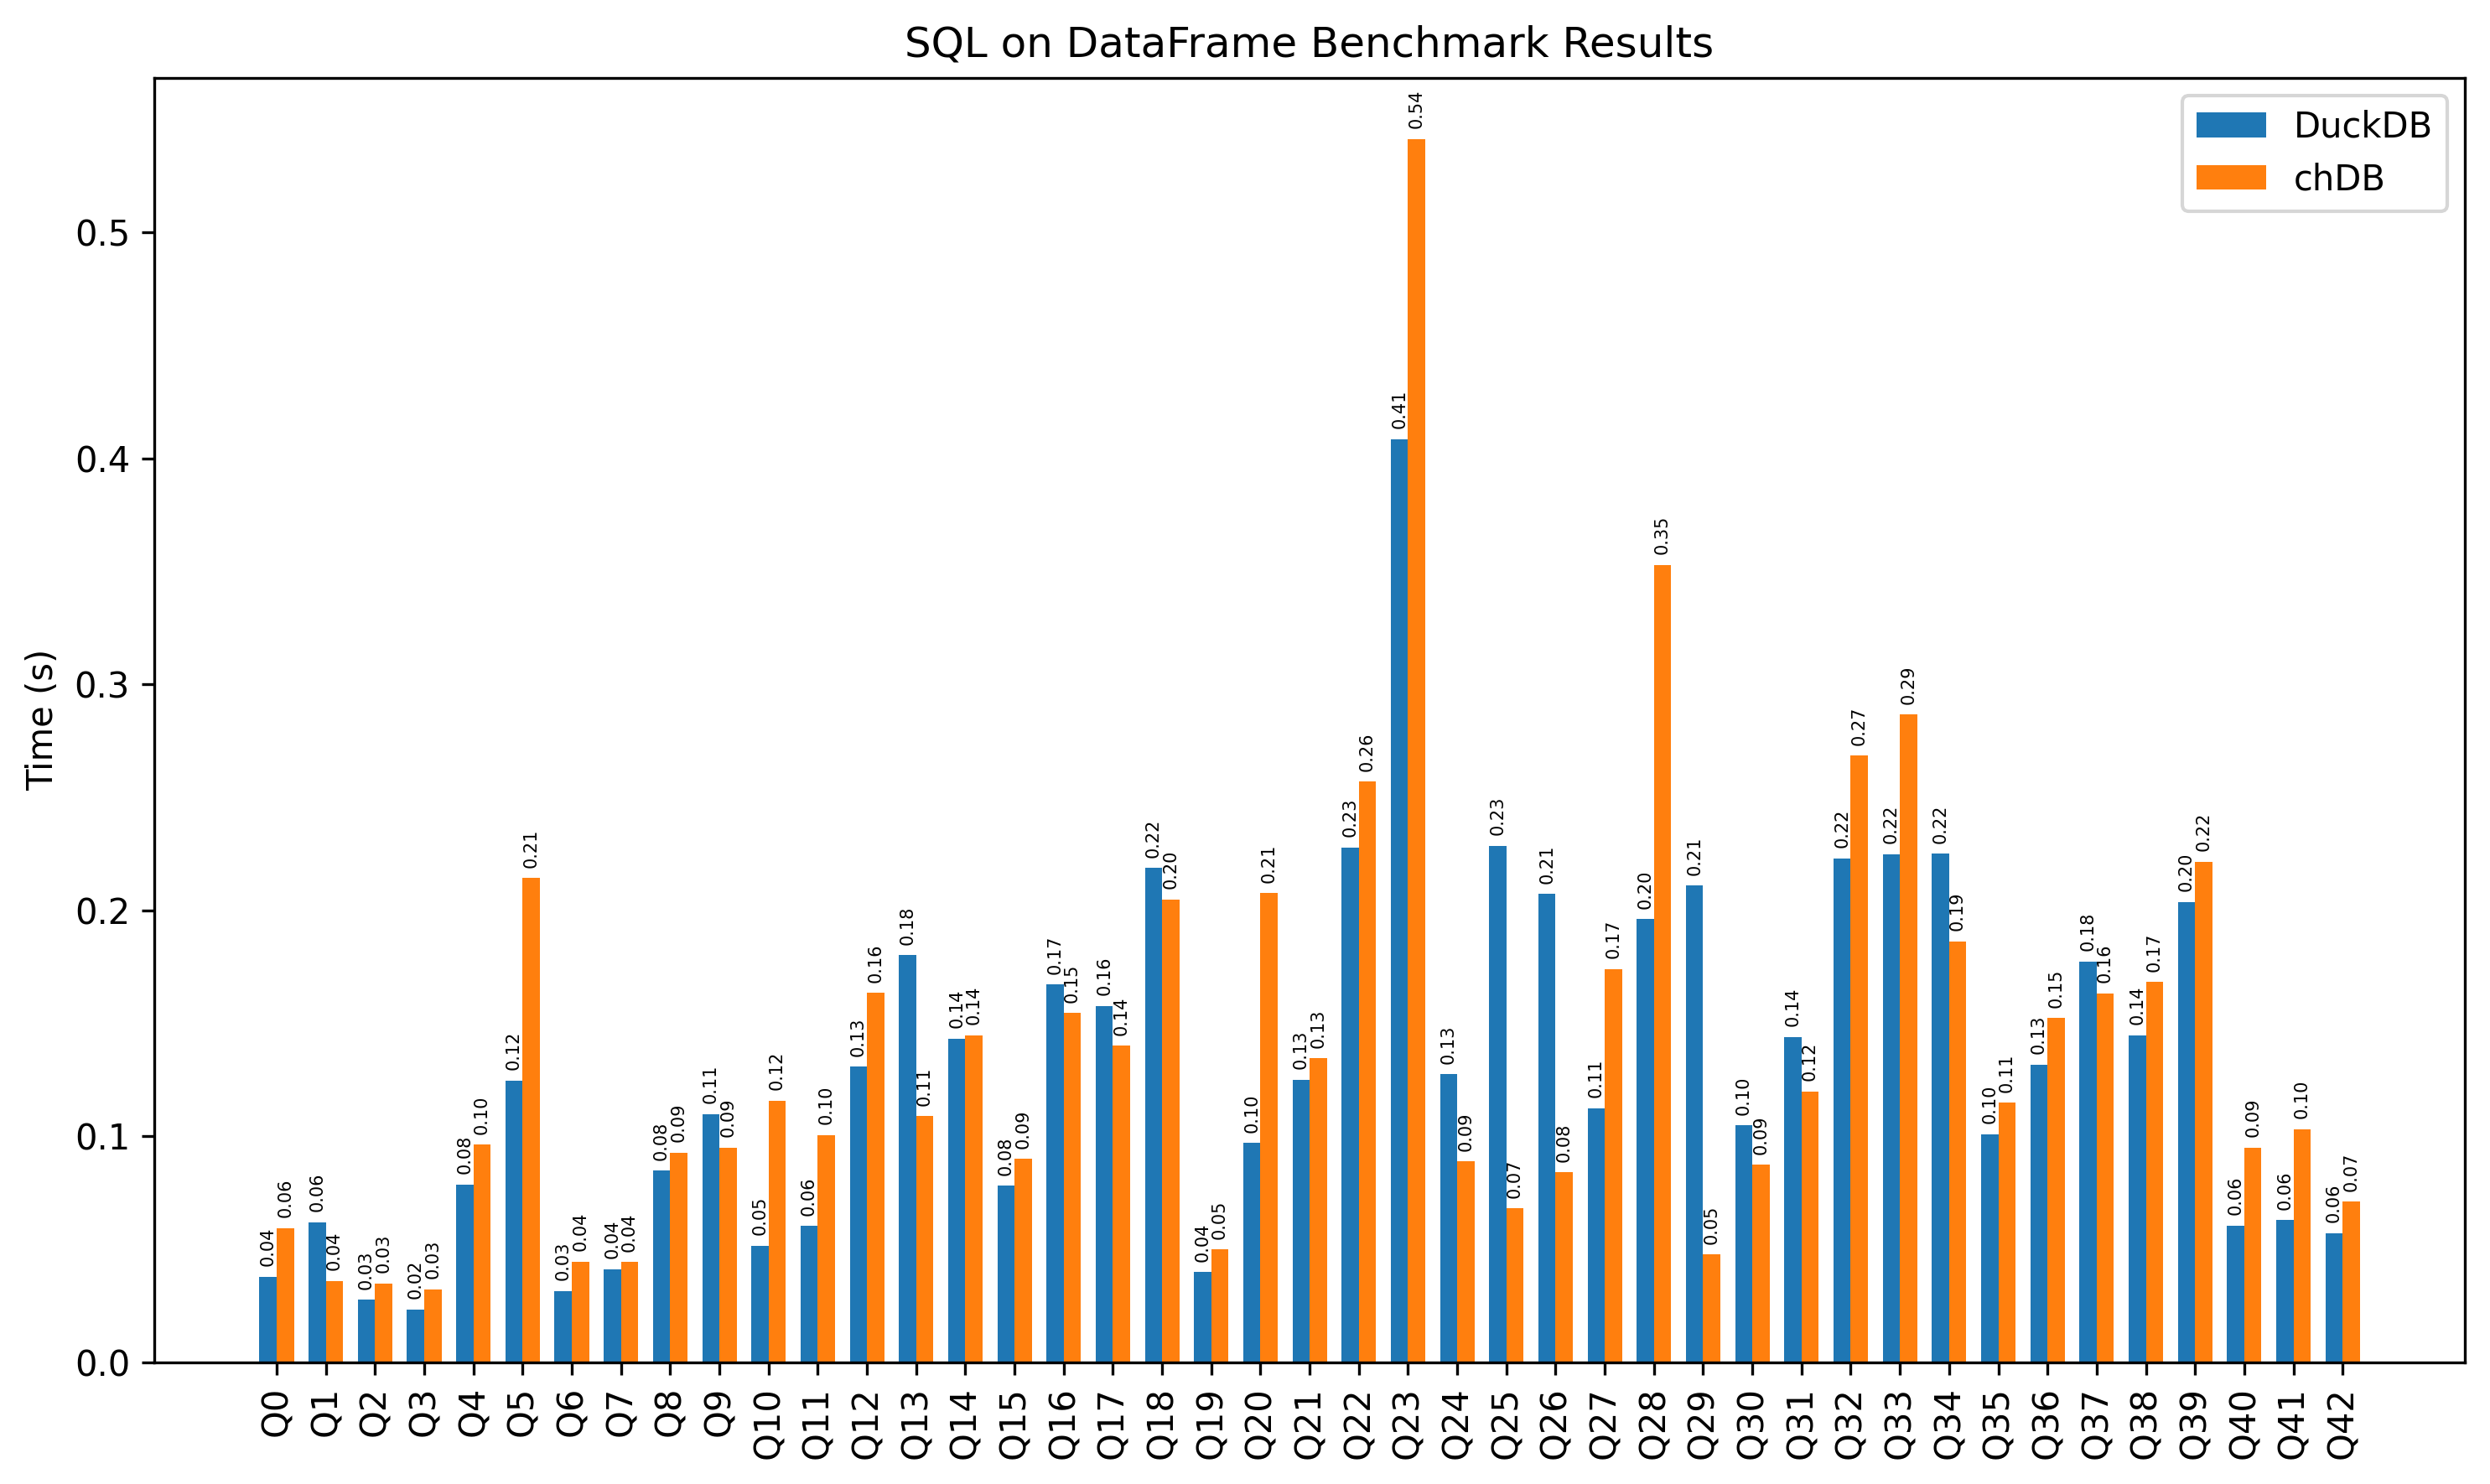

DuckDB better count: 29
chDB better count: 14
DuckDB total time: 5.650859117507935
chDB total time: 6.016231060028076


In [8]:
import matplotlib.pyplot as plt

# Benchmark results
duckdb_times = []
chdb_times = []

counter = 0
for query in queries:
    duckdb_time, chdb_time = bench(query)
    # remove the min/max time, take the average time
    if len(duckdb_time) > 2:
        duckdb_time = sorted(duckdb_time)[1:-1]
        chdb_time = sorted(chdb_time)[1:-1]

    duckdb_times.append(sum(duckdb_time) / len(duckdb_time))
    chdb_times.append(sum(chdb_time) / len(chdb_time))

x = range(len(queries))
xlable = [f"Q{num}" for num in x]
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

rects1 = ax.bar(x, duckdb_times, width, label="DuckDB")
rects2 = ax.bar([i + width for i in x], chdb_times, width, label="chDB")

ax.set_ylabel("Time (s)")
ax.set_title("SQL on DataFrame Benchmark Results")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(xlable, rotation=90)
ax.legend()

# Add the value of each bar on top
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(
        f"{height:.2f}",
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        rotation=90,  # Rotate the text 90°
        fontsize=5,  # Set the font size to a smaller value
    )


fig.tight_layout()
plt.show()

better = []
for i in range(len(queries)):
    if duckdb_times[i] < chdb_times[i]:
        better.append("DuckDB")
    else:
        better.append("chDB")
print("DuckDB better count:", better.count("DuckDB"))
print("chDB better count:", better.count("chDB"))
print("DuckDB total time:", sum(duckdb_times))
print("chDB total time:", sum(chdb_times))
